In [1]:
import os
import tensorflow as tf


def extract_genus_and_species(path):
    # Extract the folder name from the full path
    folder_name = os.path.basename(os.path.dirname(path))

    # Split the folder name assuming the format "family_genus_species"
    _, genus, species = folder_name.split("_")

    return genus, species


def get_label_index(labels_list, label):
    # Get the index of the label from the labels_list
    return labels_list.index(label)


def custom_label_function(path, genus_labels, species_labels):
    # Extract genus and species
    genus, species = extract_genus_and_species(path)

    # Convert genus and species to indices
    genus_index = get_label_index(genus_labels, genus)
    species_index = get_label_index(species_labels, species)

    return genus_index, species_index


def process_path(path, genus_labels, species_labels):
    # Load the raw data from the file as a string
    img = tf.io.read_file(path)

    # Decode the image
    img = tf.image.decode_jpeg(img, channels=3)

    # Resize the image to the desired size
    img = tf.image.resize(img, [224, 224])

    # Get the genus and species labels
    genus_label, species_label = custom_label_function(
        path, genus_labels, species_labels
    )

    # Convert to one-hot encoded format
    genus_label = tf.one_hot(genus_label, len(genus_labels))
    species_label = tf.one_hot(species_label, len(species_labels))

    return img, {"genus": genus_label, "species": species_label}


In [2]:
import os
import tensorflow as tf

def extract_genus_and_species_from_path(path):
    # TensorFlow operation to extract the folder name from the full path
    parts = tf.strings.split(path, os.sep)
    folder_name = parts[
        -2
    ]  # Assumes the structure '/.../family_genus_species/image.jpg'

    # Split the folder name assuming the format "family_genus_species"
    genus_and_species = tf.strings.split(folder_name, "_")
    genus = genus_and_species[-2]
    species = genus_and_species[-2] + " " + genus_and_species[-1]

    return genus, species


def process_path(path, genus_labels, species_labels):
    # Load the raw data from the file as a string
    img = tf.io.read_file(path)

    # Decode the image
    img = tf.image.decode_jpeg(img, channels=3)

    # Resize the image to the desired size
    img = tf.image.resize(img, [224, 224])

    # Get the genus and species labels
    genus, species = extract_genus_and_species_from_path(path)

    # Convert genus and species to indices
    genus_label = tf.argmax(tf.equal(genus_labels, genus))
    species_label = tf.argmax(tf.equal(species_labels, species))

    # Convert to one-hot encoded format
    genus_label = tf.one_hot(genus_label, len(genus_labels))
    species_label = tf.one_hot(species_label, len(species_labels))

    return img, {"genus": genus_label, "species": species_label}


def build_dataset(directory, batch_size=32):
    # Get list of all files and extract labels
    file_paths = []
    genus_labels = set()
    species_labels = set()

    for root, _, files in os.walk(directory):
        for file in files:
            if file.lower().endswith((".jpg", ".jpeg", ".png")):
                file_path = os.path.join(root, file)
                file_paths.append(file_path)

                # Extract genus and species
                folder_name = os.path.basename(os.path.dirname(file_path))
                _, genus, species = folder_name.split("_")

                species = genus + " " + species

                # Collect unique genus and species names
                genus_labels.add(genus)
                species_labels.add(species)

    # Convert sets to sorted lists to keep label indices consistent
    genus_labels = sorted(list(genus_labels))
    species_labels = sorted(list(species_labels))

    # Create a TensorFlow dataset from the file paths
    path_ds = tf.data.Dataset.from_tensor_slices(file_paths)

    # Convert genus and species labels to TensorFlow tensors
    genus_labels = tf.constant(genus_labels)
    species_labels = tf.constant(species_labels)

    # Map the processing function to the dataset
    image_label_ds = path_ds.map(
        lambda x: process_path(x, genus_labels, species_labels),
        num_parallel_calls=tf.data.AUTOTUNE,
    )

    # Shuffle, batch, and prefetch the dataset
    image_label_ds = image_label_ds.shuffle(buffer_size=len(file_paths))
    image_label_ds = image_label_ds.batch(batch_size)
    image_label_ds = image_label_ds.prefetch(buffer_size=tf.data.AUTOTUNE)

    return (
        image_label_ds,
        genus_labels.numpy().tolist(),
        species_labels.numpy().tolist(),
    )


# Usage
train_ds, genus_labels, species_labels = build_dataset(
    "/Users/leonardo/Documents/Projects/cryptovision/data/processed/train"
)
valid_ds, genus_labels, species_labels = build_dataset(
    "/Users/leonardo/Documents/Projects/cryptovision/data/processed/valid"
)
test_ds, genus_labels, species_labels = build_dataset(
    "/Users/leonardo/Documents/Projects/cryptovision/data/processed/test"
)


2024-10-17 19:26:51.191552: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M3 Pro
2024-10-17 19:26:51.191576: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 36.00 GB
2024-10-17 19:26:51.191582: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 13.50 GB
2024-10-17 19:26:51.191595: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-10-17 19:26:51.191604: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [3]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [4]:
# Model preprocess
preprocess_input = tf.keras.applications.efficientnet_v2.preprocess_input

# Data Augmentation Function
data_augmentation = tf.keras.Sequential(
    [
        tf.keras.layers.RandomFlip("horizontal"),
        tf.keras.layers.RandomRotation(0.2),
        tf.keras.layers.RandomZoom(0.2),
        tf.keras.layers.RandomTranslation(0.1, 0.1),
        tf.keras.layers.RandomContrast(0.2),
        tf.keras.layers.RandomBrightness(0.2),
        tf.keras.layers.RandomCrop(224, 224),
        tf.keras.layers.GaussianNoise(0.1),
    ]
)

In [6]:
import tensorflow as tf
from tensorflow.keras.regularizers import l1_l2

# Base model for EfficientNetV2
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(
    include_top=False, weights="imagenet", pooling="avg", input_shape=(224, 224, 3)
)

# Non-trainable layers (you can later fine-tune by setting this to True)
base_model.trainable = False

# Inputs
inputs = tf.keras.Input(shape=(224, 224, 3))

# Data augmentation and preprocessing
x = data_augmentation(inputs)  # Assuming data_augmentation is defined elsewhere
x = preprocess_input(x)  # Assuming preprocess_input is defined elsewhere
x = base_model(x, training=True)
x = tf.keras.layers.Dropout(0.2)(x)

# Shared dense layer
x_shared = tf.keras.layers.Dense(
    1024,
    # activation="relu",
    kernel_regularizer=l1_l2(l1=0.001, l2=0.001),
)(x)
x_shared = tf.keras.layers.BatchNormalization()(x_shared)
#x_shared = tf.keras.layers.Activation("relu")(x_shared)
x_shared = tf.keras.layers.LeakyReLU()(x_shared)
x_shared = tf.keras.layers.Dropout(0.2)(x_shared)

# Genus output head
output_genus = tf.keras.layers.Dense(
    len(genus_labels), activation="softmax", name="genus"
)(x_shared)

# Species-specific dense layer
x_species = tf.keras.layers.Dense(
    512,  # Additional complexity for species
    #activation="relu",
    kernel_regularizer=l1_l2(l1=0.001, l2=0.001),
)(x_shared)
x_species = tf.keras.layers.BatchNormalization()(x_species)
#x_species = tf.keras.layers.Activation('relu')(x_species)
x_shared = tf.keras.layers.LeakyReLU()(x_shared)
x_species = tf.keras.layers.Dropout(0.2)(x_species)

# Species output head
output_species = tf.keras.layers.Dense(
    len(species_labels), activation="softmax", name="species"
)(x_species)

# Final Model Setup
model = tf.keras.models.Model(inputs=inputs, outputs=[output_genus, output_species])

# Compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss={"genus": "categorical_crossentropy", "species": "categorical_crossentropy"},
    metrics={"genus": ["accuracy"], "species": ["accuracy"]},
)


# Model summary
model.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 224, 224,  │          0 │ input_layer_4[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetv2-b0   │ (None, 1280)      │  5,919,312 │ sequential[1][0]  │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 1280)      │          0 │ efficientnetv2-b… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 1024)      │  1,311,744 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1024)      │      4,096 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ leaky_re_lu_2       │ (None, 1024)      │          0 │ batch_normalizat… │
│ (LeakyReLU)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 1024)      │          0 │ leaky_re_lu_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 512)       │    524,800 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_3[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_5 (Dropout) │ (None, 512)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ genus (Dense)       │ (None, 45)        │     46,125 │ dropout_4[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ species (Dense)     │ (None, 57)        │     29,241 │ dropout_5[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,837,366 (29.90 MB)

 Trainable params: 1,914,982 (7.31 MB)

 Non-trainable params: 5,922,384 (22.59 MB)

In [4]:
import tensorflow as tf
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Add, Dense, BatchNormalization, Activation, Dropout, Input, LayerNormalization
from tensorflow.keras.models import Model

# Define a residual block for dense layers
def dense_residual_block(x, units, l1=0.001, l2=0.001):
    """
    Residual block with Dense layers and skip connection.
    """
    shortcut = x

    # First dense layer
    x = Dense(
        units,
        kernel_regularizer=l1_l2(l1=l1, l2=l2),
    )(x)
    #x = BatchNormalization()(x)
    x = LayerNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.4)(x)

    # Second dense layer
    x = Dense(
        units,
        kernel_regularizer=l1_l2(l1=l1, l2=l2),
    )(x)
    x = BatchNormalization()(x)

    # Add shortcut (ensure the dimensions match)
    if shortcut.shape[-1] != units:
        shortcut = Dense(units)(shortcut)

    x = Add()([x, shortcut])
    x = Activation("relu")(x)
    return x

# Base model for EfficientNetV2
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(
    include_top=False, weights="imagenet", pooling="avg", input_shape=(224, 224, 3)
)

# Non-trainable layers (you can later fine-tune by setting this to True)
base_model.trainable = False

# Inputs
inputs = Input(shape=(224, 224, 3))

# Data augmentation and preprocessing
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=True)

# Shared dense layer
x_shared = Dense(
    1024,
    kernel_regularizer=l1_l2(l1=0.001, l2=0.001),
)(x)
x_shared = BatchNormalization()(x_shared)
x_shared = Activation("relu")(x_shared)
x_shared = Dropout(0.2)(x_shared)

# Deepen the genus-specific path with additional dense residual blocks
x_genus = dense_residual_block(x_shared, units=512)
x_genus = dense_residual_block(x_genus, units=512)  # Add another block
#x_genus = dense_residual_block(x_genus, units=512)  # Add one more block
output_genus = Dense(
    len(genus_labels), activation="softmax", name="genus"
)(x_genus)

# Deepen the species-specific path with additional dense residual blocks
x_species = dense_residual_block(x_shared, units=512)
x_species = dense_residual_block(x_species, units=512)  # Add another block
#x_species = dense_residual_block(x_species, units=512)  # Add one more block
output_species = Dense(
    len(species_labels), activation="softmax", name="species"
)(x_species)

# Final Model Setup
model_resnet_L = Model(inputs=inputs, outputs=[output_genus, output_species])

lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-4,
    decay_steps=10000,
    decay_rate=0.9
)

# Compile the model
model_resnet_L.compile(
    #optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    #optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    optimizer = tf.keras.optimizers.AdamW(learning_rate=1e-4, weight_decay=1e-5),
    loss={"genus": "categorical_crossentropy", "species": "categorical_crossentropy"},
    metrics={"genus": ["accuracy"], "species": ["accuracy"]},
)

# Model summary
model_resnet_L.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 224, 224,  │          0 │ input_layer_1[0]… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetv2-b0   │ (None, 1280)      │  5,919,312 │ sequential[0][0]  │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1024)      │  1,311,744 │ efficientnetv2-b… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1024)      │      4,096 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1024)      │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 1024)      │          0 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 512)       │    524,800 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 512)       │    524,800 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 512)       │      1,024 │ dense_1[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 512)       │      1,024 │ dense_6[0][0]     │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 512)       │          0 │ layer_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (None, 512)       │          0 │ layer_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 512)       │          0 │ activation_1[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 512)       │          0 │ activation_5[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 512)       │    262,656 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 512)       │    262,656 │ dropout_3[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 512)       │    524,800 │ dropout[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_7[0][0]   

 Total params: 10,974,902 (41.87 MB)

 Trainable params: 5,049,446 (19.26 MB)

 Non-trainable params: 5,925,456 (22.60 MB)

In [12]:
import tensorflow as tf
from tensorflow.keras.regularizers import l1_l2
from tensorflow.keras.layers import Add, Dense, BatchNormalization, Activation, Dropout, Input
from tensorflow.keras.models import Model

# Define a residual block for dense layers
def dense_residual_block(x, units, l1=0.001, l2=0.001):
    """
    Residual block with Dense layers and skip connection.
    """
    shortcut = x

    # First dense layer
    x = Dense(
        units,
        kernel_regularizer=l1_l2(l1=l1, l2=l2),
    )(x)
    x = BatchNormalization()(x)
    x = Activation("relu")(x)
    x = Dropout(0.2)(x)

    # Second dense layer
    x = Dense(
        units,
        kernel_regularizer=l1_l2(l1=l1, l2=l2),
    )(x)
    x = BatchNormalization()(x)

    # Add shortcut (ensure the dimensions match)
    if shortcut.shape[-1] != units:
        shortcut = Dense(units)(shortcut)

    x = Add()([x, shortcut])
    x = Activation("relu")(x)
    return x

# Base model for EfficientNetV2
base_model = tf.keras.applications.efficientnet_v2.EfficientNetV2B0(
    include_top=False, weights="imagenet", pooling="avg", input_shape=(224, 224, 3)
)

# Non-trainable layers (you can later fine-tune by setting this to True)
base_model.trainable = False

# Inputs
inputs = Input(shape=(224, 224, 3))

# Data augmentation and preprocessing
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=True)

# Shared dense layer
x_shared = Dense(
    1024,
    kernel_regularizer=l1_l2(l1=0.001, l2=0.001),
)(x)
x_shared = BatchNormalization()(x_shared)
x_shared = Activation("relu")(x_shared)
x_shared = Dropout(0.2)(x_shared)

# Genus-specific dense residual block
x_genus = dense_residual_block(x_shared, units=512)
output_genus = Dense(
    len(genus_labels), activation="softmax", name="genus"
)(x_genus)

# Species-specific dense residual block
x_species = dense_residual_block(x_shared, units=512)
output_species = Dense(
    len(species_labels), activation="softmax", name="species"
)(x_species)

# Final Model Setup
model_resnet_M = Model(inputs=inputs, outputs=[output_genus, output_species])

# Compile the model
model_resnet_M.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss={"genus": "categorical_crossentropy", "species": "categorical_crossentropy"},
    metrics={"genus": ["accuracy"], "species": ["accuracy"]},
)

# Model summary
model_resnet_M.summary()

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_10      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 224, 224,  │          0 │ input_layer_10[0… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetv2-b0   │ (None, 1280)      │  5,919,312 │ sequential[4][0]  │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_43 (Dense)    │ (None, 1024)      │  1,311,744 │ efficientnetv2-b… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1024)      │      4,096 │ dense_43[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_37       │ (None, 1024)      │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_22          │ (None, 1024)      │          0 │ activation_37[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_44 (Dense)    │ (None, 512)       │    524,800 │ dropout_22[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_47 (Dense)    │ (None, 512)       │    524,800 │ dropout_22[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_44[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_47[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_38       │ (None, 512)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_40       │ (None, 512)       │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_23          │ (None, 512)       │          0 │ activation_38[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_24          │ (None, 512)       │          0 │ activation_40[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_45 (Dense)    │ (None, 512)       │    262,656 │ dropout_23[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_48 (Dense)    │ (None, 512)       │    262,656 │ dropout_24[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_45[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 9,920,182 (37.84 MB)

 Trainable params: 3,994,726 (15.24 MB)

 Non-trainable params: 5,925,456 (22.60 MB)

In [7]:
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.callbacks import TensorBoard
import os
import datetime

epochs = 20

# Set the directory for checkpoints and TensorBoard logs
checkpoint_dir = "/Users/leonardo/Documents/Projects/cryptovision/models"
log_dir = os.path.join(checkpoint_dir, "logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))

# Create the directory if it does not exist
os.makedirs(checkpoint_dir, exist_ok=True)


# Define callbacks
checkpoint_callback = ModelCheckpoint(
    filepath=os.path.join(checkpoint_dir, "best_model.keras"),
    monitor="val_loss",
    save_best_only=True,
    mode="min",
    verbose=1
)

tensorboard_callback = TensorBoard(
    log_dir=log_dir,
    histogram_freq=1,
    write_graph=True,
    write_images=True
)

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.2,
    patience=3,
    min_lr=1e-6,
    verbose=1
)

early_stop = EarlyStopping(
    monitor="val_loss",
    patience=5,
    restore_best_weights=True,
    verbose=1
)


history = model.fit(
    train_ds, 
    validation_data=valid_ds,
    epochs=epochs,
    callbacks=[early_stop, reduce_lr, checkpoint_callback, tensorboard_callback],
)

Epoch 1/20


2024-10-17 19:29:38.815381: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 129ms/step - genus_accuracy: 0.1902 - genus_loss: 3.3924 - loss: 57.5985 - species_accuracy: 0.2102 - species_loss: 3.5788
Epoch 1: val_loss improved from inf to 50.89647, saving model to /Users/leonardo/Documents/Projects/cryptovision/models/best_model.keras
181/181 ━━━━━━━━━━━━━━━━━━━━ 49s 188ms/step - genus_accuracy: 0.1909 - genus_loss: 3.3887 - loss: 57.5847 - species_accuracy: 0.2110 - species_loss: 3.5744 - val_genus_accuracy: 0.6036 - val_genus_loss: 1.8727 - val_loss: 50.8965 - val_species_accuracy: 0.6837 - val_species_loss: 1.6110 - learning_rate: 1.0000e-04
Epoch 2/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 128ms/step - genus_accuracy: 0.5695 - genus_loss: 1.6579 - loss: 49.5694 - species_accuracy: 0.5820 - species_loss: 1.6146
Epoch 2: val_loss improved from 50.89647 to 44.93662, saving model to /Users/leonardo/Documents/Projects/cryptovision/models/best_model.keras
181/181 ━━━━━━━━━━━━━━━━━━━━ 30s 165ms/step - genus_accuracy: 0.5696 - genus_loss: 1

In [20]:
model_resnet_L.layers[2].trainable = True

# Unfreeze the layers from `unfreeze_from`
for layer in model_resnet_L.layers[2].layers[:-30]:
    layer.trainable = False
    
model_resnet_L.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_12      │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 224, 224,  │          0 │ input_layer_12[0… │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ efficientnetv2-b0   │ (None, 1280)      │  5,919,312 │ sequential[5][0]  │
│ (Functional)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_50 (Dense)    │ (None, 1024)      │  1,311,744 │ efficientnetv2-b… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 1024)      │      4,096 │ dense_50[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_42       │ (None, 1024)      │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_25          │ (None, 1024)      │          0 │ activation_42[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_51 (Dense)    │ (None, 512)       │    524,800 │ dropout_25[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_56 (Dense)    │ (None, 512)       │    524,800 │ dropout_25[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 512)       │      1,024 │ dense_51[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 512)       │      1,024 │ dense_56[0][0]    │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_43       │ (None, 512)       │          0 │ layer_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_47       │ (None, 512)       │          0 │ layer_normalizat… │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_26          │ (None, 512)       │          0 │ activation_43[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_28          │ (None, 512)       │          0 │ activation_47[0]… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_52 (Dense)    │ (None, 512)       │    262,656 │ dropout_26[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_57 (Dense)    │ (None, 512)       │    262,656 │ dropout_28[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 512)       │      2,048 │ dense_52[0][0]    │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 21,073,796 (80.39 MB)

 Trainable params: 6,202,950 (23.66 MB)

 Non-trainable params: 4,771,952 (18.20 MB)

 Optimizer params: 10,098,894 (38.52 MB)

In [21]:
history_resnet_L = model_resnet_L.fit(
    train_ds, 
    validation_data=valid_ds,
    epochs=epochs,
    callbacks=[early_stop, reduce_lr, checkpoint_callback, tensorboard_callback],
)

Epoch 1/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 152ms/step - genus_accuracy: 0.8689 - genus_loss: 0.4211 - loss: 15.3544 - species_accuracy: 0.8449 - species_loss: 0.4761
Epoch 1: val_loss improved from 15.56290 to 14.29231, saving model to /Users/leonardo/Documents/Projects/cryptovision/models/best_model_resnet_L.keras
181/181 ━━━━━━━━━━━━━━━━━━━━ 36s 191ms/step - genus_accuracy: 0.8689 - genus_loss: 0.4211 - loss: 15.3526 - species_accuracy: 0.8449 - species_loss: 0.4761 - val_genus_accuracy: 0.8791 - val_genus_loss: 0.3828 - val_loss: 14.2923 - val_species_accuracy: 0.8550 - val_species_loss: 0.4484 - learning_rate: 1.0000e-04
Epoch 2/20
181/181 ━━━━━━━━━━━━━━━━━━━━ 0s 154ms/step - genus_accuracy: 0.8835 - genus_loss: 0.3786 - loss: 13.9060 - species_accuracy: 0.8742 - species_loss: 0.4207
Epoch 2: val_loss improved from 14.29231 to 13.00276, saving model to /Users/leonardo/Documents/Projects/cryptovision/models/best_model_resnet_L.keras
181/181 ━━━━━━━━━━━━━━━━━━━━ 35s 194ms/step - genu

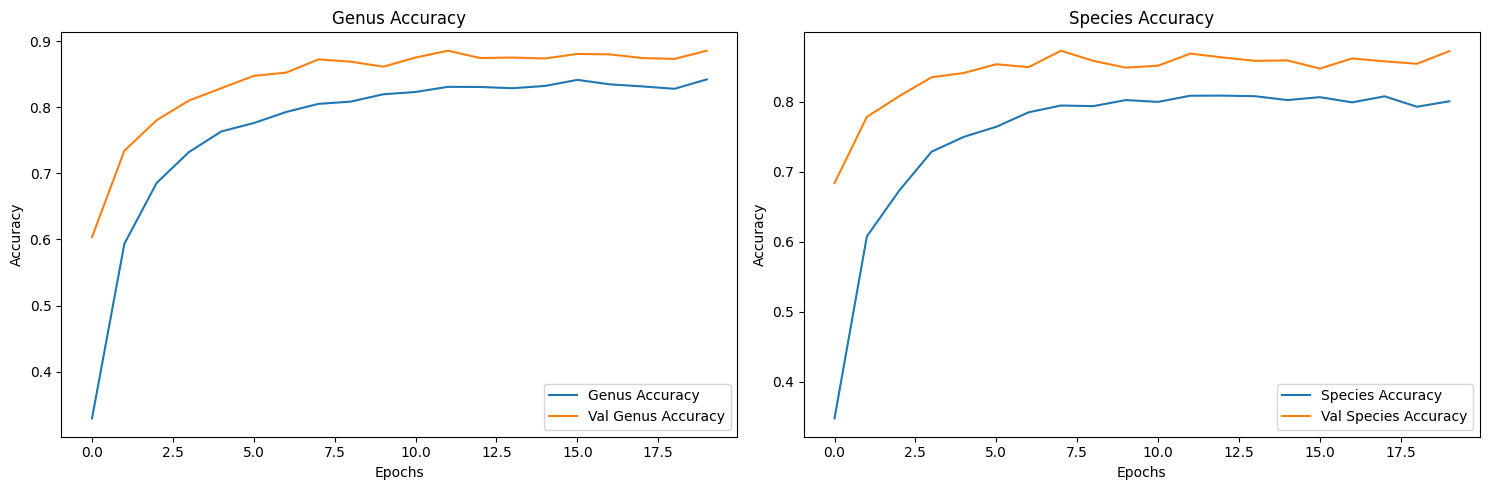

In [8]:
import matplotlib.pyplot as plt


def plot_training_history(history):
    metrics = ["accuracy"]  # , 'AUC', 'Precision', 'Recall']

    for metric in metrics:
        # Plot for Genus
        plt.figure(figsize=(15, 5))

        plt.subplot(1, 2, 1)
        plt.plot(
            history.history[f"genus_{metric}"], label=f"Genus {metric.capitalize()}"
        )
        plt.plot(
            history.history[f"val_genus_{metric}"],
            label=f"Val Genus {metric.capitalize()}",
        )
        plt.title(f"Genus {metric.capitalize()}")
        plt.xlabel("Epochs")
        plt.ylabel(metric.capitalize())
        plt.legend()

        # Plot for Species
        plt.subplot(1, 2, 2)
        plt.plot(
            history.history[f"species_{metric}"], label=f"Species {metric.capitalize()}"
        )
        plt.plot(
            history.history[f"val_species_{metric}"],
            label=f"Val Species {metric.capitalize()}",
        )
        plt.title(f"Species {metric.capitalize()}")
        plt.xlabel("Epochs")
        plt.ylabel(metric.capitalize())
        plt.legend()

        plt.tight_layout()
        plt.show()


# Assuming you have trained your model and stored the history
plot_training_history(history)

In [9]:
# Evaluate the model on the test dataset
prediction_metrics = model.evaluate(test_ds)

57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 100ms/step - genus_accuracy: 0.9039 - genus_loss: 0.3535 - loss: 6.4673 - species_accuracy: 0.8868 - species_loss: 0.4053


In [27]:
# Evaluate the model on the test dataset
prediction_metrics = model_resnet_M.evaluate(test_ds)

57/57 ━━━━━━━━━━━━━━━━━━━━ 7s 103ms/step - genus_accuracy: 0.8585 - genus_loss: 0.5031 - loss: 16.4936 - species_accuracy: 0.8338 - species_loss: 0.5378


In [9]:
# Evaluate the model on the test dataset
prediction_metrics = model.evaluate(test_ds)

# Print out the accuracy for genus and species
# print(f"Test Genus Accuracy: {prediction_metrics[4]:.4f}")
# print(f"Test Species Accuracy: {prediction_metrics[3]:.4f}")

57/57 ━━━━━━━━━━━━━━━━━━━━ 6s 94ms/step - genus_accuracy: 0.8651 - genus_loss: 0.4713 - loss: 10.2401 - species_accuracy: 0.8578 - species_loss: 0.5176


In [13]:
import numpy as np
import tensorflow as tf


def predict_image(image_path, model, genus_labels, species_labels, top_k=3):
    """
    Predict the top-k genus and species from an image using a trained model.

    Args:
    - image_path (str): Path to the image file.
    - model (tf.keras.Model): The trained model.
    - genus_labels (list): List of genus labels.
    - species_labels (list): List of species labels.
    - top_k (int): Number of top predictions to return.

    Returns:
    - top_k_genus: List of tuples (genus, confidence) for top k genus predictions.
    - top_k_species: List of tuples (species, confidence) for top k species predictions.
    """

    # Load and preprocess the image
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [224, 224])
    img = tf.expand_dims(img, 0)  # Add batch dimension

    # Predict genus and species
    genus_preds, species_preds = model.predict(img)

    # Get top-k predictions for genus
    top_k_genus_indices = np.argsort(genus_preds[0])[-top_k:][::-1]
    top_k_genus = [(genus_labels[i], genus_preds[0][i]) for i in top_k_genus_indices]

    # Get top-k predictions for species
    top_k_species_indices = np.argsort(species_preds[0])[-top_k:][::-1]
    top_k_species = [
        (species_labels[i], species_preds[0][i]) for i in top_k_species_indices
    ]

    return top_k_genus, top_k_species


# Example usage
#image_path = '/Users/leonardo/Documents/Projects/cryptovision/data/processed/test/Pseudochromidae_Cypho_purpurascens/52551_web_Cypho_purpurascens_151.jpeg'
# image_path = '/Users/leonardo/Documents/Projects/cryptovision/data/processed/test/Gobiidae_Eviota_melasma/70108_web_Eviota_melasma_52.jpeg'
# image_path = '/Users/leonardo/Documents/Projects/cryptovision/data/processed/test/Gobiidae_Eviota_melasma/fish_photo_1050.jpeg'
#image_path = "/Users/leonardo/Documents/Projects/cryptovision/data/processed/test/Blenniidae_Ecsenius_stictus/94362_web_Ecsenius_stictus_8.jpeg"
# image_path = '/Users/leonardo/Documents/Projects/cryptovision/data/processed/test/Gobiidae_Gobiodon_quinquestrigatus/59583_web_Gobiodon_quinquestrigatus_56.jpeg'
# image_path = '/Users/leonardo/Documents/Projects/cryptovision/data/processed/test/Apogonidae_Apogon_binotatus/web_Apogon_binotatus_13.jpeg'
#image_path = '/Users/leonardo/Documents/Projects/cryptovision/data/processed/test/Tripterygiidae_Enneapterygius_tutuilae/web_Enneapterygius_tutuilae_3.jpeg'
image_path = '/Users/leonardo/Documents/Projects/cryptovision/data/processed/test/Blenniidae_Ecsenius_pulcher/fish_photo_17597.jpeg'
#image_path = "/Users/leonardo/Documents/Projects/cryptovision/data/processed/test/Gobiidae_Aioliops_megastigma/97261_web_Aioliops_megastigma_21.jpeg"
# image_path = "/Users/leonardo/Documents/Projects/cryptovision/data/processed/test/Tripterygiidae_Helcogramma_fuscopinna/web_Helcogramma_fuscopinna_25.jpeg"



top_k_genus, top_k_species = predict_image(
    image_path, model, genus_labels, species_labels, top_k=3
)

print("Top 3 Genus Predictions:")
for genus, confidence in top_k_genus:
    print(f"{genus}: {confidence:.4f}")

print("\nTop 3 Species Predictions:")
for species, confidence in top_k_species:
    print(f"{species}: {confidence:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
Top 3 Genus Predictions:
b'Ecsenius': 0.9904
b'Cirripectes': 0.0045
b'Pristiapogon': 0.0020

Top 3 Species Predictions:
b'Ecsenius pulcher': 0.9999
b'Cirripectes variolosus': 0.0000
b'Ostorhinchus angustatus': 0.0000
